In [1]:
import pandas as pd


df = pd.read_csv('spy_2020_2022.csv')


print(df.head())
print(df.columns)


/var/folders/jr/08yvytz57bg9yfk_fhb69hwc0000gn/T/ipykernel_7649/3265676987.py:4: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('spy_2020_2022.csv')


   [QUOTE_UNIXTIME]   [QUOTE_READTIME]  [QUOTE_DATE]   [QUOTE_TIME_HOURS]  \
0        1630526400   2021-09-01 16:00    2021-09-01                 16.0   
1        1630526400   2021-09-01 16:00    2021-09-01                 16.0   
2        1630526400   2021-09-01 16:00    2021-09-01                 16.0   
3        1630526400   2021-09-01 16:00    2021-09-01                 16.0   
4        1630526400   2021-09-01 16:00    2021-09-01                 16.0   

    [UNDERLYING_LAST]  [EXPIRE_DATE]   [EXPIRE_UNIX]   [DTE]  [C_DELTA]  \
0              451.85     2021-09-01      1630526400     0.0   1.000000   
1              451.85     2021-09-01      1630526400     0.0   1.000000   
2              451.85     2021-09-01      1630526400     0.0   1.000000   
3              451.85     2021-09-01      1630526400     0.0   1.000000   
4              451.85     2021-09-01      1630526400     0.0   1.000000   

   [C_GAMMA]  ...   [P_LAST]   [P_DELTA]  [P_GAMMA]    [P_VEGA]   [P_THETA]  \
0   0.0

On procède maintenant à un nettoyage de la base de données 

In [2]:
df.columns = df.columns.str.strip().str.replace('[', '', regex=False).str.replace(']', '', regex=False)


On sépare le data frame en deux, un avec les données pour les calls et un avec les données pour les puts, le but étant de faciliter le traitement par la suite, en raison de la disjonction de cas dans le formule du calcul théorique (Black and Scholes) 

In [3]:
# calls
df_calls = df[['QUOTE_DATE', 'EXPIRE_DATE', 'DTE', 'UNDERLYING_LAST', 'STRIKE',
               'C_BID', 'C_ASK', 'C_LAST', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME']].copy()

# puts
df_puts = df[['QUOTE_DATE', 'EXPIRE_DATE', 'DTE', 'UNDERLYING_LAST', 'STRIKE',
              'P_BID', 'P_ASK', 'P_LAST', 'P_IV', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_VOLUME']].copy()


Contrôle du contenu des deux nouveaux dataframes

In [4]:
print(df_calls.head())
print(df_puts.head())

    QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE        C_BID  \
0   2021-09-01   2021-09-01  0.0           451.85   270.0   181.090000   
1   2021-09-01   2021-09-01  0.0           451.85   275.0   176.090000   
2   2021-09-01   2021-09-01  0.0           451.85   280.0   171.090000   
3   2021-09-01   2021-09-01  0.0           451.85   285.0   166.140000   
4   2021-09-01   2021-09-01  0.0           451.85   290.0   161.090000   

         C_ASK       C_LAST C_IV    C_DELTA    C_GAMMA     C_VEGA    C_THETA  \
0   182.310000   182.650000        1.000000   0.000000   0.000000   0.000000   
1   177.310000     0.000000        1.000000   0.000000   0.000000   0.000000   
2   172.310000   157.750000        1.000000   0.000000   0.000000   0.000000   
3   167.300000   153.450000        1.000000   0.000000   0.000000   0.000000   
4   162.310000   147.760000        1.000000   0.000000   0.000000   0.000000   

       C_RHO    C_VOLUME  
0   0.005170    1.000000  
1   0.005270        

Pour de la gestion de suavegarde, on enregistre nos nouveaux data frames au format CSV dans l'ordinateur pour limiter les pertes de temps à chaque redémarage

In [5]:
df_calls.to_csv('spy_calls.csv', index=False)
df_puts.to_csv('spy_puts.csv', index=False)

Nous allons avant tout, commencer par traçer la courbe du prix du sous-jacent avec le prix dit "au close" du S&P500.

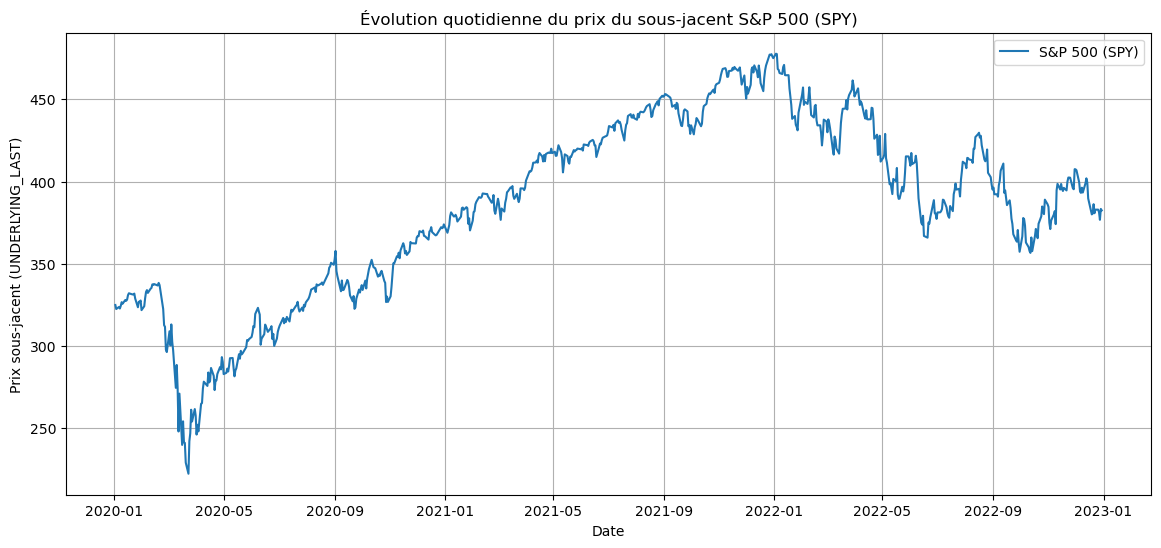

In [7]:
import matplotlib.pyplot as plt

df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])

# groupement par date et prendre la moyenne du prix sous-jacent, car on a plusieurs fois le même prix pour des strike différents, ce qui fausse donc la représentation graphique 
df_daily = df.groupby('QUOTE_DATE')['UNDERLYING_LAST'].mean().reset_index()


plt.figure(figsize=(14,6))
plt.plot(df_daily['QUOTE_DATE'], df_daily['UNDERLYING_LAST'], label='S&P 500 (SPY)')

plt.title("Évolution quotidienne du prix du sous-jacent S&P 500 (SPY)")
plt.xlabel("Date")
plt.ylabel("Prix sous-jacent (UNDERLYING_LAST)")
plt.grid()
plt.legend()
plt.show()




A l'aide de la formule basique de Black and Scholes nous allons recalculer le prix théorique des différentes options, d'abord pour les calls, puis pour les puts. Les différentes variables à prendre en compte dans la formule était le prix du sous jacent ['UNDERLYING_LAST'], le Time To Mutrity ou Date To Expiry ['DTE'], le taux d'intérêt sans risque (on prendra 1%, i.e r=0,01 pour que la valeur soit représentative sur la période concernée), le strike ou prix d'exercice de l'option ['STRIKE'] et finalement la volatilité historique que l'on va calculer.

Avant de pouvoir repérer des anomalie de pricing, nous allons calculer la volatilité hisorique du S&P 500 sur la période 2020 - 2022 en utilisant la méthode Close to Close, car c'est la seule que l'on peut utiliser avec notre data frame, une méthode telle que celle de Yang And Zang serait plus précise, mais nous ne disposons pas des des donnée Open, High et Low dans le data frame, les variations intraday seront donc sous représenter, mais ce n'est pas tant que ça un problème, car le sprix des options ne sont pas des prix intraday mais bien des prix de clôture à chaque fois. On choisira des fenêtres "rolling window" de 30 jours. 

In [8]:
#on commence par créer un dataframe avec seulement les données daily du SPX pour faire les calculs avant de faire un lerge de data frame 
import numpy as np
df_spx_daily = df.groupby('QUOTE_DATE')['UNDERLYING_LAST'].first().reset_index()

In [9]:
# calcul des log-returns
df_spx_daily['log_ret'] = np.log(df_spx_daily['UNDERLYING_LAST'] / df_spx_daily['UNDERLYING_LAST'].shift(1))

# calcul de la volatilité historique annualisée (rolling window)
window = 30  
df_spx_daily['hist_vol'] = df_spx_daily['log_ret'].rolling(window=window).std() * np.sqrt(252)

Représentation graphique de l'évolution de la volatilité historique du SPX, afin de vérifier la qualité des données avant de réaliser le merge des data frames : 

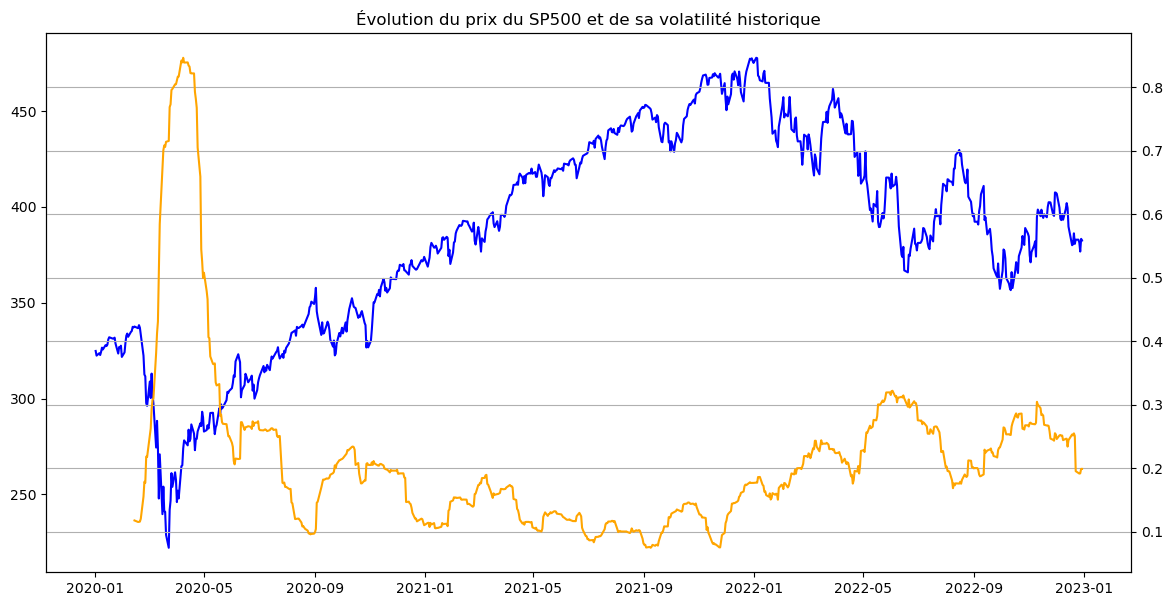

In [10]:
plt.figure(figsize=(14,7))

# prix du SPX
plt.plot(df_spx_daily['QUOTE_DATE'], df_spx_daily['UNDERLYING_LAST'], label='Prix SPY (Sous-jacent)', color='blue')

# volatilité historique 
plt.twinx()
plt.plot(df_spx_daily['QUOTE_DATE'], df_spx_daily['hist_vol'], label='Volatilité historique 30j', color='orange')

plt.title('Évolution du prix du SP500 et de sa volatilité historique')
plt.xlabel('Date')
plt.grid()
plt.show()

Maintenant nous allons réaliser des lerge sur les data frames df_calls et df_puts

In [11]:
# on verifie et on force la conversion des dates pour que le merge se fasse bien sur des index identiques 
df_calls['QUOTE_DATE'] = pd.to_datetime(df_calls['QUOTE_DATE'])
df_puts['QUOTE_DATE'] = pd.to_datetime(df_puts['QUOTE_DATE'])

# merge de la volatilité historique sur les deux datasets
df_calls = pd.merge(df_calls, df_spx_daily[['QUOTE_DATE', 'hist_vol']], on='QUOTE_DATE', how='left')
df_puts = pd.merge(df_puts, df_spx_daily[['QUOTE_DATE', 'hist_vol']], on='QUOTE_DATE', how='left')


On va maintenant vérifier l'apparence des data frame 

In [12]:
print(df_calls[['QUOTE_DATE', 'UNDERLYING_LAST', 'hist_vol']].head(10))
print(df_puts[['QUOTE_DATE', 'UNDERLYING_LAST', 'hist_vol']].head(10))


  QUOTE_DATE  UNDERLYING_LAST  hist_vol
0 2021-09-01           451.85  0.079257
1 2021-09-01           451.85  0.079257
2 2021-09-01           451.85  0.079257
3 2021-09-01           451.85  0.079257
4 2021-09-01           451.85  0.079257
5 2021-09-01           451.85  0.079257
6 2021-09-01           451.85  0.079257
7 2021-09-01           451.85  0.079257
8 2021-09-01           451.85  0.079257
9 2021-09-01           451.85  0.079257
  QUOTE_DATE  UNDERLYING_LAST  hist_vol
0 2021-09-01           451.85  0.079257
1 2021-09-01           451.85  0.079257
2 2021-09-01           451.85  0.079257
3 2021-09-01           451.85  0.079257
4 2021-09-01           451.85  0.079257
5 2021-09-01           451.85  0.079257
6 2021-09-01           451.85  0.079257
7 2021-09-01           451.85  0.079257
8 2021-09-01           451.85  0.079257
9 2021-09-01           451.85  0.079257


Commençons par implémenter une fonction qui nous permet d'utiliser la formule de black and Scholes pour les calls :

In [44]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """
    S : prix du sous-jacent
    K : prix d'exercice
    T : temps jusqu'à maturité en années
    r : taux sans risque ici on prendre 0.01 pour 1%
    sigma : volatilité annualisée
    """
    if T <= 0 or sigma <= 0:
        return max(0, S - K)  # valeur intrinsèque si maturité atteinte ou sigma nul

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price


On va maintenant d'abord traiter le data frame des calls et calculer le prix théorique des calls, avec notre taux d'intérêt sans risque que l'on fixe à 1%

In [45]:

r = 0.01  

#prix théorique pour chaque ligne
df_calls['C_THEO_PRICE'] = df_calls.apply(lambda row: black_scholes_call(
    row['UNDERLYING_LAST'],
    row['STRIKE'],
    row['DTE'] / 252,
    r,
    row['hist_vol']
) if not (pd.isna(row['UNDERLYING_LAST']) or pd.isna(row['STRIKE']) or pd.isna(row['DTE']) or pd.isna(row['hist_vol'])) else np.nan, axis=1)


In [46]:
df_calls.head(20)

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE        C_BID  \
0  2021-09-01   2021-09-01  0.0           451.85   270.0   181.090000   
1  2021-09-01   2021-09-01  0.0           451.85   275.0   176.090000   
2  2021-09-01   2021-09-01  0.0           451.85   280.0   171.090000   
3  2021-09-01   2021-09-01  0.0           451.85   285.0   166.140000   
4  2021-09-01   2021-09-01  0.0           451.85   290.0   161.090000   
5  2021-09-01   2021-09-01  0.0           451.85   295.0   156.100000   
6  2021-09-01   2021-09-01  0.0           451.85   300.0   151.100000   
7  2021-09-01   2021-09-01  0.0           451.85   305.0   146.150000   
8  2021-09-01   2021-09-01  0.0           451.85   310.0   141.100000   
9  2021-09-01   2021-09-01  0.0           451.85   315.0   136.100000   
10 2021-09-01   2021-09-01  0.0           451.85   320.0   131.360000   
11 2021-09-01   2021-09-01  0.0           451.85   325.0   126.360000   
12 2021-09-01   2021-09-01  0.0           451.85   330.0   121.360000   
13 2021-09-01   2021-09-01  0.0           451.85   335.0   116.160000   
14 2021-09-01   2021-09-01  0.0           451.85   340.0   111.360000   
15 2021-09-01   2021-09-01  0.0           451.85   345.0   106.360000   
16 2021-09-01   2021-09-01  0.0           451.85   350.0   101.360000   
17 2021-09-01   2021-09-01  0.0           451.85   355.0    94.810000   
18 2021-09-01   2021-09-01  0.0           451.85   360.0    91.360000   
19 2021-09-01   2021-09-01  0.0           451.85   365.0    86.340000   

          C_ASK  C_LAST C_IV    C_DELTA    C_GAMMA     C_VEGA     C_THETA  \
0    182.310000  182.65        1.000000   0.000000   0.000000    0.000000   
1    177.310000    0.00        1.000000   0.000000   0.000000    0.000000   
2    172.310000  157.75        1.000000   0.000000   0.000000    0.000000   
3    167.300000  153.45        1.000000   0.000000   0.000000    0.000000   
4    162.310000  147.76        1.000000   0.000000   0.000000    0.000000   
5    157.300000  143.46        1.000000   0.000000   0.000000    0.000000   
6    152.300000  138.51        1.000000   0.000000   0.000000   -0.000170   
7    147.310000  134.11        1.000000   0.000000   0.000000   -0.000130   
8    142.300000    0.00        1.000000   0.000000   0.000000   -0.000370   
9    137.300000  137.09        1.000000   0.000000   0.000000    0.000000   
10   132.090000    0.00        1.000000   0.000000   0.000000   -0.000150   
11   127.100000  119.21        1.000000   0.000000   0.000000   -0.000440   
12   122.100000  114.02        1.000000   0.000000   0.000000   -0.000450   
13   117.300000  108.35        1.000000   0.000000   0.000000    0.000000   
14   112.100000  103.75        1.000000   0.000000   0.000000   -0.000480   
15   107.100000   98.76        1.000000   0.000000   0.000000    0.000000   
16   102.100000   97.67        1.000000   0.000000   0.000000   -0.000050   
17    98.530000   96.34        1.000000   0.000000   0.000000   -0.000220   
18    92.100000   81.79        1.000000   0.000000   0.000000    0.000000   
19    87.070000    0.00        1.000000   0.000000   0.000000    0.000000   

        C_RHO    C_VOLUME  hist_vol  C_THEO_PRICE  ecart_absolu  
0    0.005170    1.000000  0.079257        181.85          0.80  
1    0.005270              0.079257        176.85       -176.85  
2    0.005690   25.000000  0.079257        171.85        -14.10  
3    0.005300   25.000000  0.079257        166.85        -13.40  
4    0.005340   25.000000  0.079257        161.85        -14.09  
5    0.005510   25.000000  0.079257        156.85        -13.39  
6    0.005630   24.000000  0.079257        151.85        -13.34  
7    0.006060   24.000000  0.079257        146.85        -12.74  
8    0.006450              0.079257        141.85       -141.85  
9    0.006150   10.000000  0.079257        136.85          0.24  
10   0.006120              0.079257        131.85       -131.85  
11   0.006030   24.000000  0.079257        126.85         -

Nous allons maintenant rajouter une colonne au data frame, qui me sure l'écart entre le prix théorique et le prix réel:

In [47]:
df_calls['C_LAST'] = pd.to_numeric(df_calls['C_LAST'], errors='coerce')
df_calls['C_THEO_PRICE'] = pd.to_numeric(df_calls['C_THEO_PRICE'], errors='coerce')


In [48]:
df_calls['ecart_absolu'] = df_calls['C_LAST'] - df_calls['C_THEO_PRICE']
df_calls.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE        C_BID  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   181.090000   
1 2021-09-01   2021-09-01  0.0           451.85   275.0   176.090000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   171.090000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   166.140000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   161.090000   

         C_ASK  C_LAST C_IV    C_DELTA    C_GAMMA     C_VEGA    C_THETA  \
0   182.310000  182.65        1.000000   0.000000   0.000000   0.000000   
1   177.310000    0.00        1.000000   0.000000   0.000000   0.000000   
2   172.310000  157.75        1.000000   0.000000   0.000000   0.000000   
3   167.300000  153.45        1.000000   0.000000   0.000000   0.000000   
4   162.310000  147.76        1.000000   0.000000   0.000000   0.000000   

       C_RHO    C_VOLUME  hist_vol  C_THEO_PRICE  ecart_absolu  
0   0.005170    1.000000  0.079257        181.85          0.80  
1   0.005270              0.079257        176.85       -176.85  
2   0.005690   25.000000  0.079257        171.85        -14.10  
3   0.005300   25.000000  0.079257        166.85        -13.40  
4   0.005340   25.000000  0.079257        161.85        -14.09

On remarque un problème, c'est que certaines fois il y a des problèmes dans le data frame et le prix du C_LAST est à 0, alors que le bid et l'ask sont bien différents de 0, on vas donc choisir d'éliminer ces cas là, dans le but d'éviter d'avoir des valeurs ab"rrantes qui auraient un impacte trop fort sur les modèles de deep learning que l'on appliquera dessu par la suite. 

In [49]:
df_calls_clean = df_calls[df_calls['C_LAST'] > 0].copy()

In [50]:
df_calls_clean.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE        C_BID  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   181.090000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   171.090000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   166.140000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   161.090000   
5 2021-09-01   2021-09-01  0.0           451.85   295.0   156.100000   

         C_ASK  C_LAST C_IV    C_DELTA    C_GAMMA     C_VEGA    C_THETA  \
0   182.310000  182.65        1.000000   0.000000   0.000000   0.000000   
2   172.310000  157.75        1.000000   0.000000   0.000000   0.000000   
3   167.300000  153.45        1.000000   0.000000   0.000000   0.000000   
4   162.310000  147.76        1.000000   0.000000   0.000000   0.000000   
5   157.300000  143.46        1.000000   0.000000   0.000000   0.000000   

       C_RHO    C_VOLUME  hist_vol  C_THEO_PRICE  ecart_absolu  
0   0.005170    1.000000  0.079257        181.85          0.80  
2   0.005690   25.000000  0.079257        171.85        -14.10  
3   0.005300   25.000000  0.079257        166.85        -13.40  
4   0.005340   25.000000  0.079257        161.85        -14.09  
5   0.005510   25.000000  0.079257        156.85        -13.39

Des écarts seront toujours présents entre notre prix théorique et le prix réel pour plusieurs raisons : 
- le prix du close n'est pas vraizment représentatif du prix réel qui se forme à l'aide du spread bid/ask 
- la méthode de clacul utilisée est la méthode de volatilité close to close, un GARCH ou un Yang & Zang aurait été plus adapté, mais au vu des données dont on dispose dans le data frame à notre diposition, il s'agissait du choix le plus optimal. 

C'est pourquoi, nous allons utiliser une méthode des quantiles pour déterminer quelles sont les options sur ou sous pricées, les données sont empiriques, avec beaucoup de bruit et d'hétérogénité. Au lieu de fixer un écart "acceptable" de façon arbitraire, la méthode des quantiles nous permet de nous adapter à notre distribution réelle, on cherhce des annomalies larges donc on prendre les quantiles 10% et 90 %. 

Nous allons ensuite utiliser une méthode de classement qui sera adaptée pour l'application de reéaseaux de neuronnes avec la classification suivante : 
- sur-pricé : '1'
- sous -pricé : '-1'
- fair price : '0'

In [51]:
q_low = df_calls_clean['ecart_absolu'].quantile(0.10)
q_high = df_calls_clean['ecart_absolu'].quantile(0.90)

In [52]:
df_calls_clean['label'] = np.where(
    df_calls_clean['ecart_absolu'] > q_high, 1,
    np.where(df_calls_clean['ecart_absolu'] < q_low, -1, 0)
)


In [53]:
df_calls_clean.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE        C_BID  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   181.090000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   171.090000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   166.140000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   161.090000   
5 2021-09-01   2021-09-01  0.0           451.85   295.0   156.100000   

         C_ASK  C_LAST C_IV    C_DELTA    C_GAMMA     C_VEGA    C_THETA  \
0   182.310000  182.65        1.000000   0.000000   0.000000   0.000000   
2   172.310000  157.75        1.000000   0.000000   0.000000   0.000000   
3   167.300000  153.45        1.000000   0.000000   0.000000   0.000000   
4   162.310000  147.76        1.000000   0.000000   0.000000   0.000000   
5   157.300000  143.46        1.000000   0.000000   0.000000   0.000000   

       C_RHO    C_VOLUME  hist_vol  C_THEO_PRICE  ecart_absolu  label  
0   0.005170    1.000000  0.079257        181.85          0.80      0  
2   0.005690   25.000000  0.079257        171.85        -14.10      0  
3   0.005300   25.000000  0.079257        166.85        -13.40      0  
4   0.005340   25.000000  0.079257        161.85        -14.09      0  
5   0.005510   25.000000  0.079257        156.85        -13.39      0

In [54]:
df_calls_clean['label'].value_counts()

label
 0    2346402
-1     282394
 1     282394
Name: count, dtype: int64

Nous allons maintenaant procéder exactement à la même opération mais avec les puts 

In [31]:
def black_scholes_put(S, K, T, r, sigma):
    """
    S : prix du sous-jacent
    K : prix d'exercice (strike)
    T : temps jusqu'à maturité (en années)
    r : taux sans risque
    sigma : volatilité annualisée
    """
    if T <= 0 or sigma <= 0:
        return max(0, K - S)  # Valeur intrinsèque si maturité atteinte ou sigma nul

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

In [33]:

r = 0.01  

#prix théorique pour chaque ligne
df_puts['P_THEO_PRICE'] = df_puts.apply(lambda row: black_scholes_put(
    row['UNDERLYING_LAST'],
    row['STRIKE'],
    row['DTE'] / 252,
    r,
    row['hist_vol']
) if not (pd.isna(row['UNDERLYING_LAST']) or pd.isna(row['STRIKE']) or pd.isna(row['DTE']) or pd.isna(row['hist_vol'])) else np.nan, axis=1)

In [34]:
df_puts.head(20)

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE      P_BID  \
0  2021-09-01   2021-09-01  0.0           451.85   270.0   0.000000   
1  2021-09-01   2021-09-01  0.0           451.85   275.0   0.000000   
2  2021-09-01   2021-09-01  0.0           451.85   280.0   0.000000   
3  2021-09-01   2021-09-01  0.0           451.85   285.0   0.000000   
4  2021-09-01   2021-09-01  0.0           451.85   290.0   0.000000   
5  2021-09-01   2021-09-01  0.0           451.85   295.0   0.000000   
6  2021-09-01   2021-09-01  0.0           451.85   300.0   0.000000   
7  2021-09-01   2021-09-01  0.0           451.85   305.0   0.000000   
8  2021-09-01   2021-09-01  0.0           451.85   310.0   0.000000   
9  2021-09-01   2021-09-01  0.0           451.85   315.0   0.000000   
10 2021-09-01   2021-09-01  0.0           451.85   320.0   0.000000   
11 2021-09-01   2021-09-01  0.0           451.85   325.0   0.000000   
12 2021-09-01   2021-09-01  0.0           451.85   330.0   0.000000   
13 2021-09-01   2021-09-01  0.0           451.85   335.0   0.000000   
14 2021-09-01   2021-09-01  0.0           451.85   340.0   0.000000   
15 2021-09-01   2021-09-01  0.0           451.85   345.0   0.000000   
16 2021-09-01   2021-09-01  0.0           451.85   350.0   0.000000   
17 2021-09-01   2021-09-01  0.0           451.85   355.0   0.000000   
18 2021-09-01   2021-09-01  0.0           451.85   360.0   0.000000   
19 2021-09-01   2021-09-01  0.0           451.85   365.0   0.000000   

        P_ASK     P_LAST       P_IV     P_DELTA     P_GAMMA      P_VEGA  \
0    0.010000   0.010000   3.412490   -0.000240    0.000000    0.000040   
1    0.010000   0.010000   3.297370   -0.000630    0.000030    0.000190   
2    0.010000   0.010000   3.183300    0.000000    0.000000   -0.000230   
3    0.010000   0.010000   3.072170   -0.000160    0.000040    0.000380   
4    0.010000   0.010000   2.962300   -0.000680    0.000000    0.000450   
5    0.010000   0.040000   2.854330   -0.000520   -0.000030    0.000400   
6    0.010000   0.010000   2.748420   -0.000300   -0.000010    0.000240   
7    0.010000   0.020000   2.643920   -0.000550    0.000060    0.000550   
8    0.010000   0.080000   2.540760   -0.000780   -0.000020    0.000040   
9    0.010000   0.000000   2.438860   -0.000480   -0.000010    0.000090   
10   0.010000   0.010000   2.339100   -0.000390    0.000080    0.000250   
11   0.010000   0.010000   2.239610   -0.000080    0.000000    0.000360   
12   0.010000   0.020000   2.142450   -0.000390    0.000080    0.000740   
13   0.010000   0.020000   2.046200    0.000000    0.000090    0.000700   
14   0.010000   0.010000   1.950870   -0.000690    0.000070    0.000810   
15   0.010000   0.010000   1.857480   -0.000330    0.000090    0.000290   
16   0.010000   0.010000   1.764530   -0.000030    0.000070    0.000060   
17   0.010000   0.010000   1.672900   -0.000460    0.000040    0.000450   
18   0.010000   0.010000   1.582390   -0.000210    0.000090    0.000450   
19   0.010000   0.020000   1.492490   -0.000640    0.000050    0.000740   

       P_THETA      P_RHO       P_VOLUME  hist_vol  P_THEO_PRICE  
0    -0.005090   0.000000       3.000000  0.079257           0.0  
1    -0.004800   0.000000       0.000000  0.079257           0.0  
2    -0.005340   0.000000      11.000000  0.079257           0.0  
3    -0.005320   0.000000      50.000000  0.079257           0.0  
4    -0.005150   0.000000       0.000000  0.079257           0.0  
5    -0.004950   0.000000       1.000000  0.079257           0.0  
6    -0.004750   0.000000       3.000000  0.079257           0.0  
7    -0.004950   0.000000       0.000000  0.079257           0.0  
8    -0.005360   0.000000       1.000000  0.079257           0.0  
9    -0.004860   0.000000                 0.079257           0.0  
10   -0.005390   0.000000       1.000000  0.079257           0.0  
11   -0.005340   0.000000       3.000000  0.079257           0.0  
12   -0.004820   0.000000      13.000000  0.079257           0.0

In [37]:
df_puts['P_LAST'] = pd.to_numeric(df_puts['P_LAST'], errors='coerce')
df_puts['P_THEO_PRICE'] = pd.to_numeric(df_puts['P_THEO_PRICE'], errors='coerce')

In [38]:
df_puts['ecart_absolu'] = df_puts['P_LAST'] - df_puts['P_THEO_PRICE']
df_puts.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE      P_BID      P_ASK  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   0.000000   0.010000   
1 2021-09-01   2021-09-01  0.0           451.85   275.0   0.000000   0.010000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   0.000000   0.010000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   0.000000   0.010000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   0.000000   0.010000   

   P_LAST       P_IV     P_DELTA    P_GAMMA      P_VEGA     P_THETA  \
0    0.01   3.412490   -0.000240   0.000000    0.000040   -0.005090   
1    0.01   3.297370   -0.000630   0.000030    0.000190   -0.004800   
2    0.01   3.183300    0.000000   0.000000   -0.000230   -0.005340   
3    0.01   3.072170   -0.000160   0.000040    0.000380   -0.005320   
4    0.01   2.962300   -0.000680   0.000000    0.000450   -0.005150   

       P_RHO    P_VOLUME  hist_vol  P_THEO_PRICE  ecart_absolu  
0   0.000000    3.000000  0.079257           0.0          0.01  
1   0.000000    0.000000  0.079257           0.0          0.01  
2   0.000000   11.000000  0.079257           0.0          0.01  
3   0.000000   50.000000  0.079257           0.0          0.01  
4   0.000000    0.000000  0.079257           0.0          0.01

In [39]:
df_puts_clean = df_puts[df_puts['P_LAST'] > 0].copy()

In [40]:
q_low_bis = df_puts_clean['ecart_absolu'].quantile(0.10)
q_high_bis = df_puts_clean['ecart_absolu'].quantile(0.90)

In [41]:
df_puts_clean['label'] = np.where(
    df_puts_clean['ecart_absolu'] > q_high_bis, 1,
    np.where(df_puts_clean['ecart_absolu'] < q_low_bis, -1, 0)
)

In [42]:
df_puts_clean.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE      P_BID      P_ASK  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   0.000000   0.010000   
1 2021-09-01   2021-09-01  0.0           451.85   275.0   0.000000   0.010000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   0.000000   0.010000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   0.000000   0.010000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   0.000000   0.010000   

   P_LAST       P_IV     P_DELTA    P_GAMMA      P_VEGA     P_THETA  \
0    0.01   3.412490   -0.000240   0.000000    0.000040   -0.005090   
1    0.01   3.297370   -0.000630   0.000030    0.000190   -0.004800   
2    0.01   3.183300    0.000000   0.000000   -0.000230   -0.005340   
3    0.01   3.072170   -0.000160   0.000040    0.000380   -0.005320   
4    0.01   2.962300   -0.000680   0.000000    0.000450   -0.005150   

       P_RHO    P_VOLUME  hist_vol  P_THEO_PRICE  ecart_absolu  label  
0   0.000000    3.000000  0.079257           0.0          0.01      0  
1   0.000000    0.000000  0.079257           0.0          0.01      0  
2   0.000000   11.000000  0.079257           0.0          0.01      0  
3   0.000000   50.000000  0.079257           0.0          0.01      0  
4   0.000000    0.000000  0.079257           0.0          0.01      0

In [59]:
df_puts_clean['label'].value_counts()



label
 0    2340953
 1     280906
-1     280906
Name: count, dtype: int64

Nous allons maintenant déterminer les données qui peuvent être considérées comme des "features intéressants", le but est d'éliminer les données qui ne sont pas utiles ou pas directement reliées à notre problématique dans les data frames pour éviter au plus les faux positifs ou le sur apprentissage par le réseau de neurones.

Nous avons donc choisi, pour chaque data frame de garder les données suivantes : 
- Prix du sous-jacent 
- strike de l'option 
- Date jsq maturité 
- Volatilité historique 
- Greeks (Delta, Gamma, Vegga, Rhô ; Theta)

De plus dans les deux data frame nous allons rajouter la donnée suivante : 
- la distance entre le prix du sous-jacent et le strike de l'option 
- la moneyness 



In [60]:
df_calls_clean['distance_strike'] = df_calls_clean['STRIKE'] - df_calls_clean['UNDERLYING_LAST']
df_calls_clean['moneyness'] = df_calls_clean['UNDERLYING_LAST'] / df_calls_clean['STRIKE']


In [61]:
df_puts_clean['distance_strike'] = df_puts_clean['STRIKE'] - df_puts_clean['UNDERLYING_LAST']
df_puts_clean['moneyness'] = df_puts_clean['UNDERLYING_LAST'] / df_puts_clean['STRIKE']

In [62]:
df_puts_clean.head()

QUOTE_DATE  EXPIRE_DATE  DTE  UNDERLYING_LAST  STRIKE      P_BID      P_ASK  \
0 2021-09-01   2021-09-01  0.0           451.85   270.0   0.000000   0.010000   
1 2021-09-01   2021-09-01  0.0           451.85   275.0   0.000000   0.010000   
2 2021-09-01   2021-09-01  0.0           451.85   280.0   0.000000   0.010000   
3 2021-09-01   2021-09-01  0.0           451.85   285.0   0.000000   0.010000   
4 2021-09-01   2021-09-01  0.0           451.85   290.0   0.000000   0.010000   

   P_LAST       P_IV     P_DELTA  ...      P_VEGA     P_THETA      P_RHO  \
0    0.01   3.412490   -0.000240  ...    0.000040   -0.005090   0.000000   
1    0.01   3.297370   -0.000630  ...    0.000190   -0.004800   0.000000   
2    0.01   3.183300    0.000000  ...   -0.000230   -0.005340   0.000000   
3    0.01   3.072170   -0.000160  ...    0.000380   -0.005320   0.000000   
4    0.01   2.962300   -0.000680  ...    0.000450   -0.005150   0.000000   

     P_VOLUME  hist_vol  P_THEO_PRICE  ecart_absolu  label  distance_strike  \
0    3.000000  0.079257           0.0          0.01      0          -181.85   
1    0.000000  0.079257           0.0          0.01      0          -176.85   
2   11.000000  0.079257           0.0          0.01      0          -171.85   
3   50.000000  0.079257           0.0          0.01      0          -166.85   
4    0.000000  0.079257           0.0          0.01      0          -161.85   

   moneyness  
0   1.673519  
1   1.643091  
2   1.613750  
3   1.585439  
4   1.558103  

[5 rows x 21 columns]

On fait maintenant le fitrage des data frames en enlevant les données inutiles( dates...) ainsi que les données qu'on a déjà labellié (P_THEO_PRICE, ecart_absolu...)

Commençons pas les calls : 

In [65]:
features_calls = ['UNDERLYING_LAST', 'STRIKE', 'DTE', 'hist_vol',
            'distance_strike', 'moneyness',
            'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO']

df_model_calls = df_calls_clean[features_calls + ['label']].dropna()


On va maintenant séparer features et target 

In [66]:
X = df_model_calls[features_calls]
y = df_model_calls['label']

On va maintenant un petit  peu observer nos données et en faire un état des lieux: 

In [67]:
df_model_calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823932 entries, 0 to 3589078
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   UNDERLYING_LAST  float64
 1   STRIKE           float64
 2   DTE              float64
 3   hist_vol         float64
 4   distance_strike  float64
 5   moneyness        float64
 6   C_DELTA          object 
 7   C_GAMMA          object 
 8   C_VEGA           object 
 9   C_THETA          object 
 10  C_RHO            object 
 11  label            int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 280.1+ MB


On remarque que nos greeks ne sont pas des floats mais des object, ce qui pourrait biaiser toute la suite, on va donc forceer leur passage en float 

In [69]:
cols_to_convert = ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO']

for col in cols_to_convert:
    df_model_calls[col] = pd.to_numeric(df_model_calls[col], errors='coerce')


In [70]:
df_model_calls.describe().T.round(2)

count    mean     std      min     25%     50%     75%  \
UNDERLYING_LAST  2823932.0  388.03   56.61   222.21  348.33  394.78  434.65   
STRIKE           2823932.0  380.98  103.45     5.00  315.00  384.00  445.00   
DTE              2823932.0  161.94  205.68     0.00   20.00   77.96  226.04   
hist_vol         2823932.0    0.22    0.15     0.07    0.13    0.18    0.25   
distance_strike  2823932.0   -7.05   90.76  -445.68  -48.96   -1.83   36.52   
moneyness        2823932.0    1.11    0.75     0.44    0.91    1.00    1.15   
C_DELTA          2823932.0    0.50    0.37     0.00    0.09    0.54    0.87   
C_GAMMA          2823932.0    0.01    0.01    -0.00    0.00    0.00    0.01   
C_VEGA           2823932.0    0.46    7.39 -2222.40    0.07    0.30    0.72   
C_THETA          2823932.0   -0.06    0.08    -7.16   -0.08   -0.04   -0.01   
C_RHO            2823932.0    0.51    6.05 -2587.50    0.02    0.15    0.63   
label            2823932.0    0.00    0.45    -1.00    0.00    0.00    0.00   

                     max  
UNDERLYING_LAST   477.77  
STRIKE            720.00  
DTE              1096.00  
hist_vol            0.85  
distance_strike   363.42  
moneyness          71.56  
C_DELTA             1.00  
C_GAMMA             2.31  
C_VEGA            147.33  
C_THETA             0.00  
C_RHO             333.37  
label               1.00

On va faire un catplot pour vérifier que la répartition des nombre de calls par strike est cohérente dans tout le data frame :

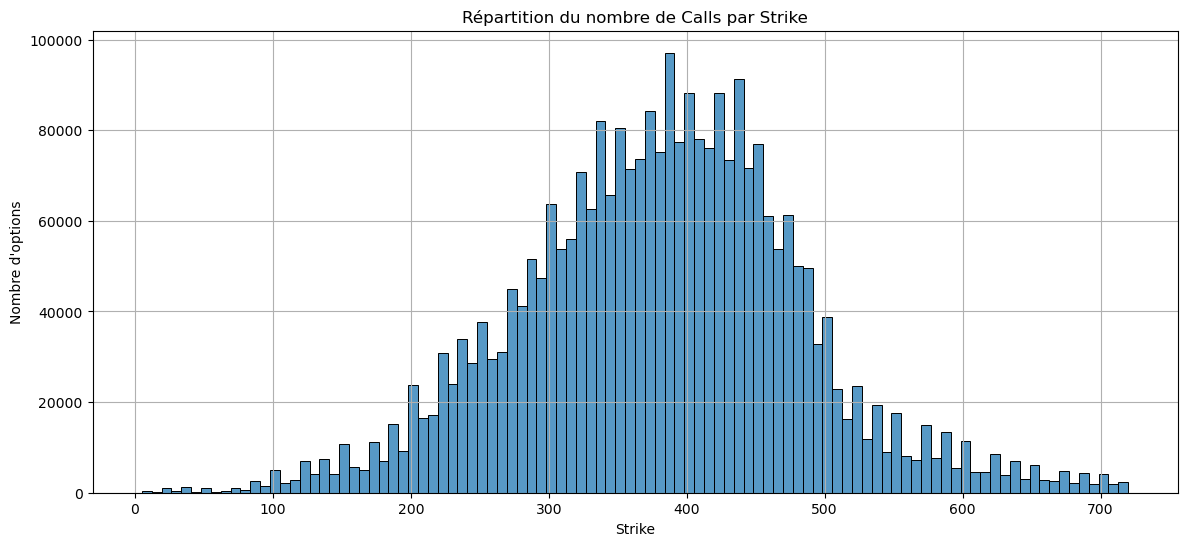

In [71]:
import seaborn as sns
plt.figure(figsize=(14,6))
sns.histplot(df_model_calls['STRIKE'], bins=100, kde=False)
plt.title("Répartition du nombre de Calls par Strike")
plt.xlabel("Strike")
plt.ylabel("Nombre d'options")
plt.grid()
plt.show()

Cette répartition est bien logique, car les émetteurs d'options listent des strikes de plus en plus espacés aux extrêmes pour éviter d'avoir un nombre trop important d'option trop OTM donc illiquides. 

De plus la concentration se fait autour de 300 - 400, ce qui est cohérent au vu des prix de l'ETF SPX sur la période.
Comme les market markers et investisseurs se postionnent autour des prix du spot, plus de contrats sont créer à ces niveaux. 

On ne cherche pas à retirer des outliers en plus, car nous avon spris soin de déjà retirer les valeurs aberrantes plus haut et que ce sont pour nous les aberrations dans le pricing du marché qui nous intéressent pour faire un max de PNLLLL.

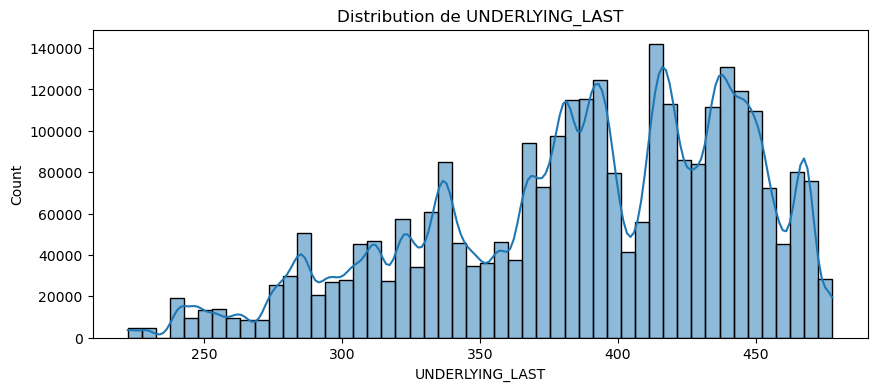

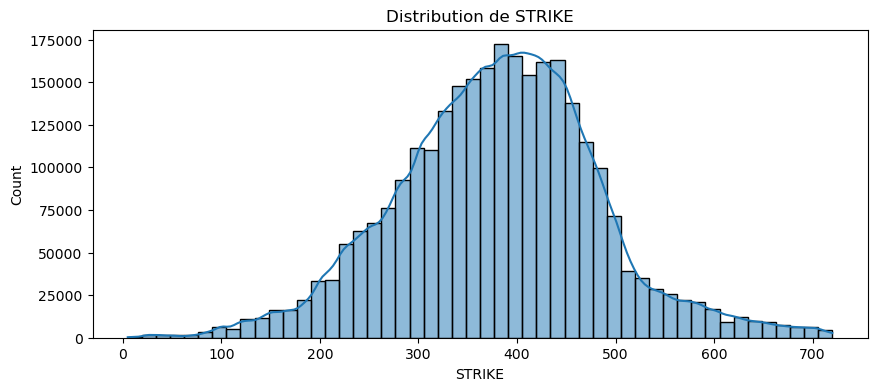

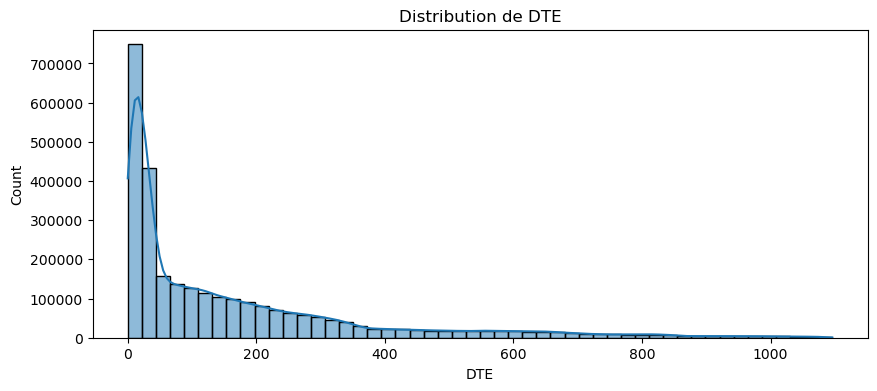

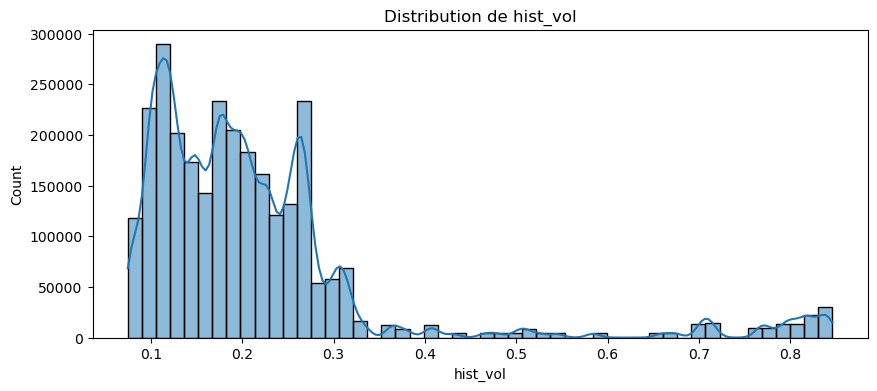

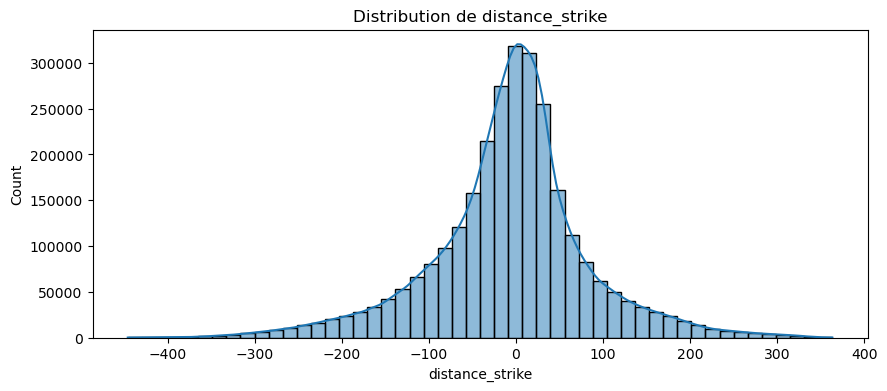

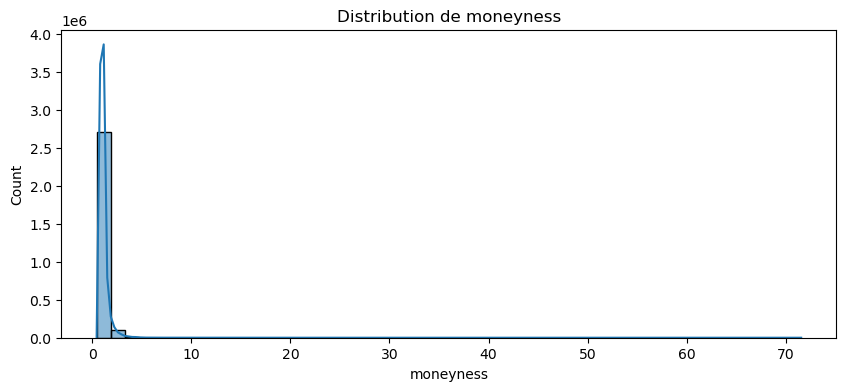

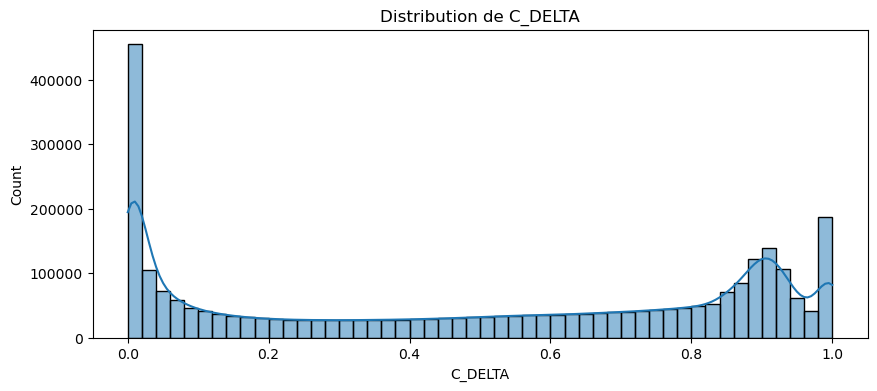

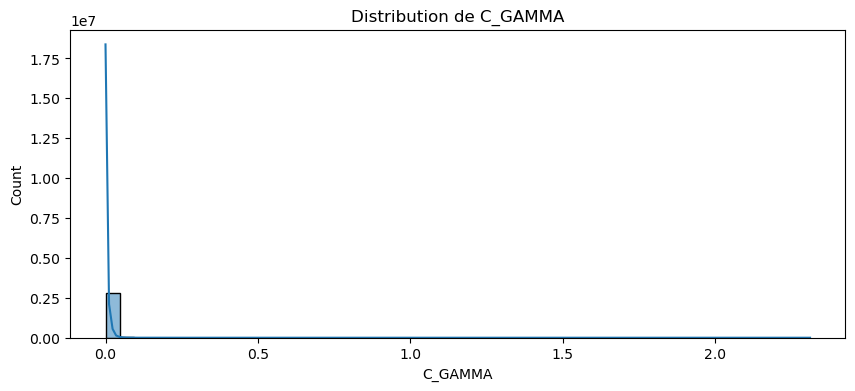

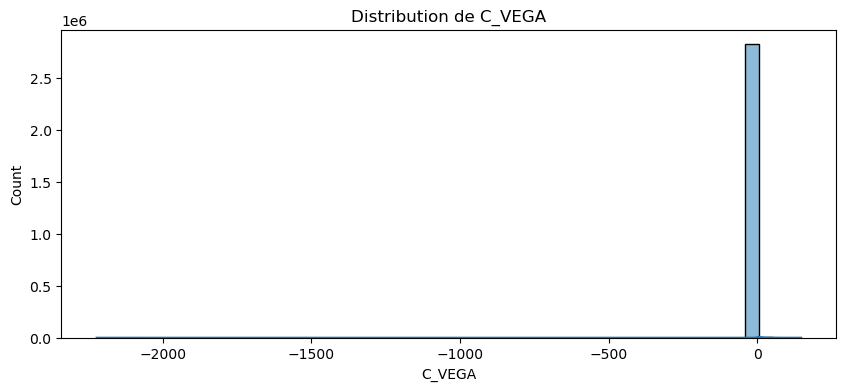

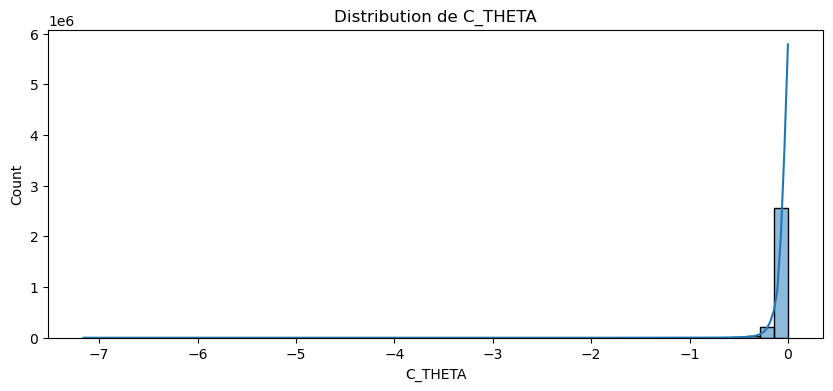

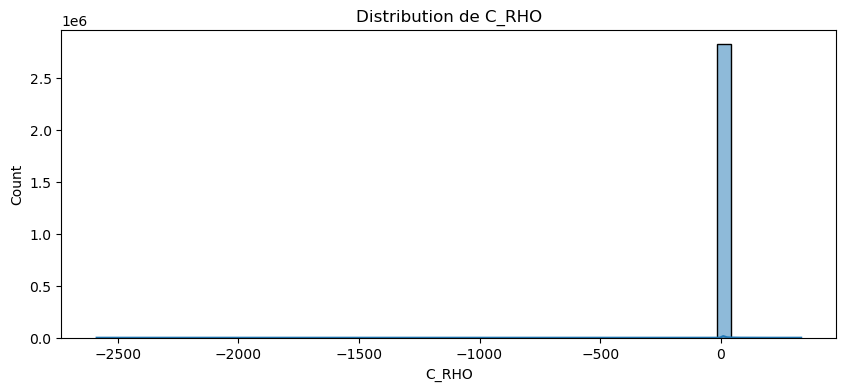

In [72]:
for col in features_calls:
    plt.figure(figsize=(10,4))
    sns.histplot(df_model_calls[col], bins=50, kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

On ve pas tout commenter, car l'objet du travail n'est pas ici, mais les données sont complètement logiques. 

On va maintenant faire un pairplot avec corrélation par 'label', au vu de la taille gargantuesque de notre base de données (millions de lignes) on va prendre un petit semble mais qui reste assez significatif : 

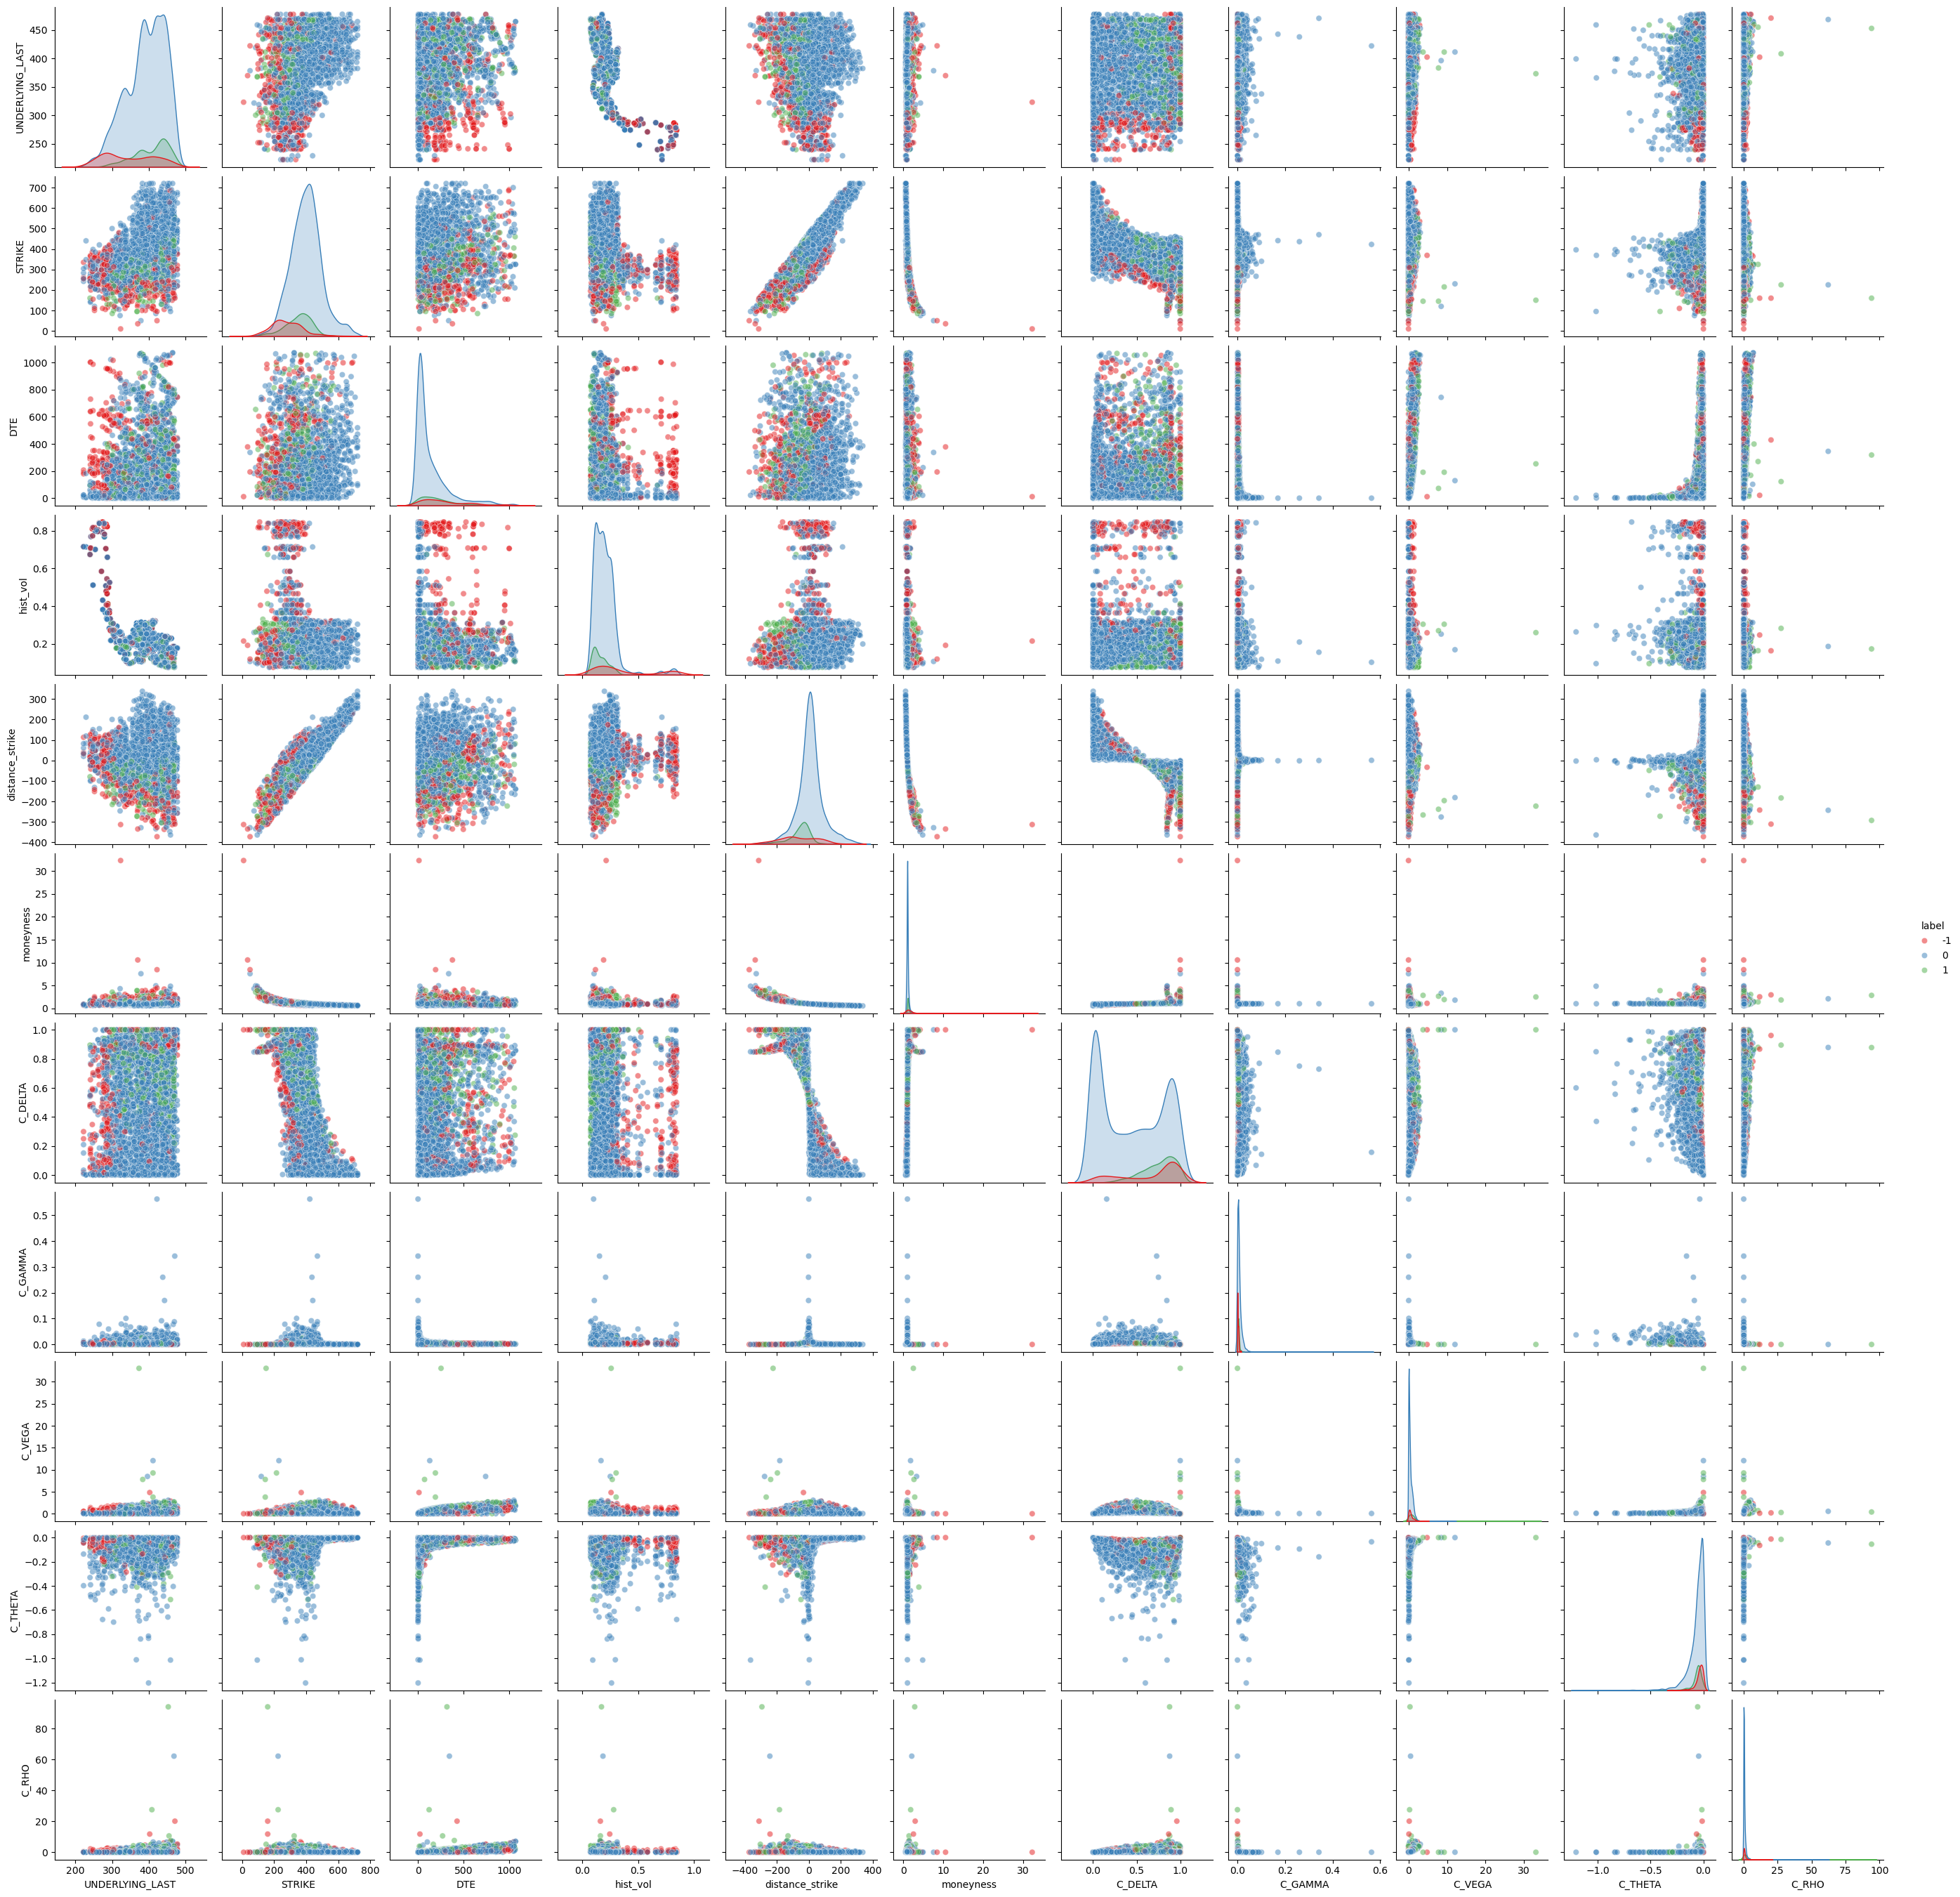

In [73]:
df_sample = df_model_calls.sample(5000, random_state=42)

sns.pairplot(df_sample, vars=features_calls, hue='label', palette='Set1', plot_kws={'alpha':0.5})
plt.show()


Les conclusions que l'on peut tirer de ce pairplot : 
- on remarque que les anomalies sont concentrées sur les options avec des strikes très éloignés (Out Of The Money - OTM) ce qui est complètement logique 
- les anomalies sont fortement présentes en cas de choc extrême de volatilité, ce qui est aussi logique 
- Les valeurs de greeks élevées décrivent bien une forte sensibilité liée à la forte corrélation, ce qui est aussi logique 

Le dataset semble complètement réaliste par rapport à la réalité ainsi que la littérature académique sur le pricing d'options, ce qui est plus qu'une bonne nouvelle après tout ce travail, l'inverse aurait été facheux!

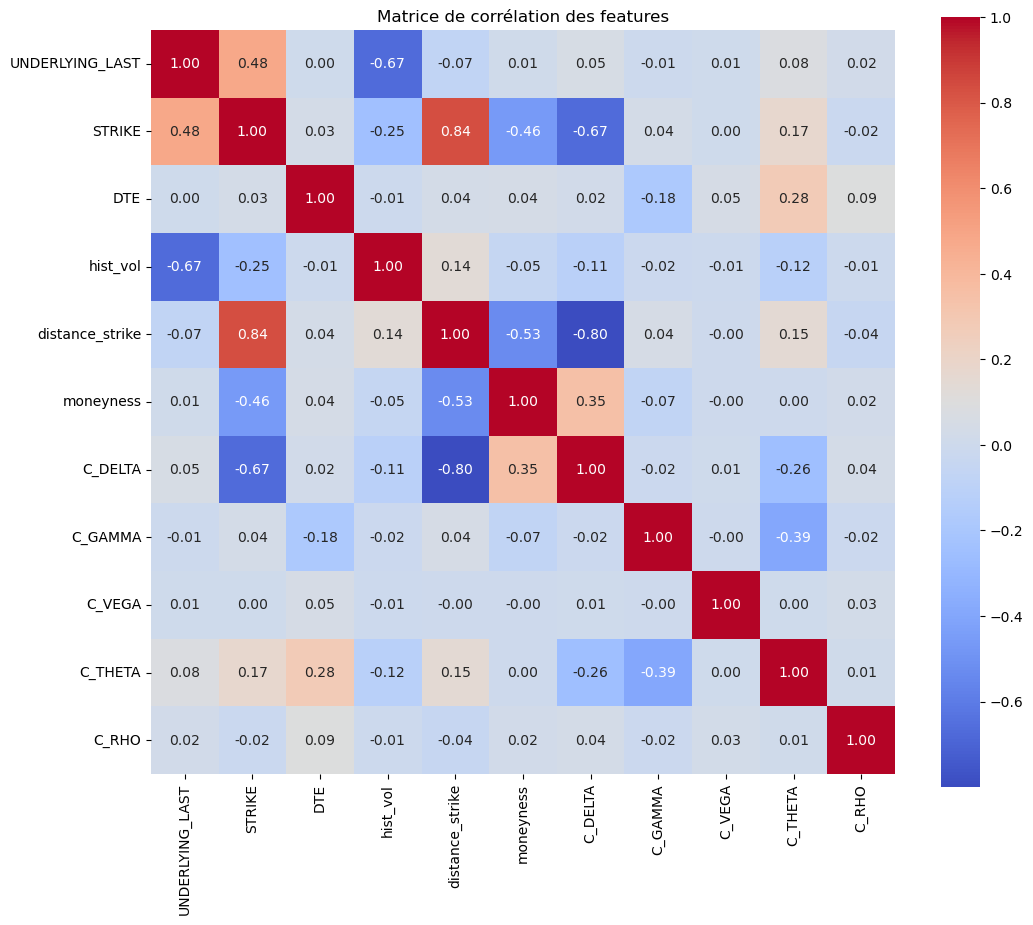

In [74]:
#uniquement les features numériques
features_calls = ['UNDERLYING_LAST', 'STRIKE', 'DTE', 'hist_vol',
            'distance_strike', 'moneyness',
            'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO']


corr_matrix = df_model_calls[features_calls].corr()


plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation des features")
plt.show()

On épargnera toute cette analyse du contenu des données quand on ferra tourner pour les puts, il s'agissait juste de vérifier ici que les données etaient cohérentes, reprenons donc, maintenant que nous avons séparer le label des features

Nous allons maintenant utiliser plusieurs modèles, le but étant de faire varier différents paramètres sur les réseaux de neurones que l'on va utiliser pour voir quelles sont les influences de chaque changements et ensuite nous chercherons à déterminer ce qui pourrait-être le modèle le plus adapté. 


Nous allons mettre en place une cross validation pour entrâiner les modèles pour chercher à avoir plus de précision, voici sur une illustration simpla à quoi ressemble la cross validation (il s'agit d'une image sur un modèle avec un K Fold qui n'a rien à voir avec notre exemple)

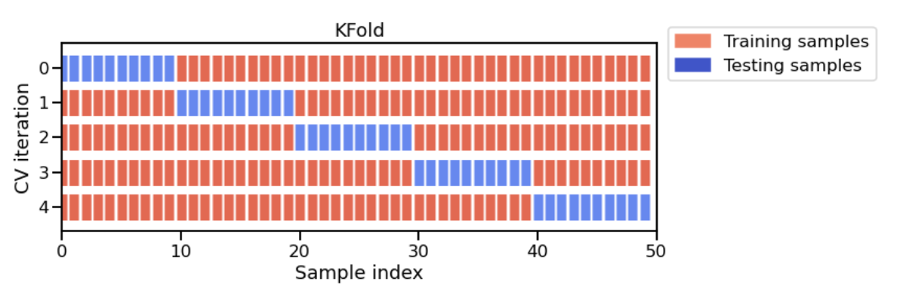

On va commencer par modifier l'encodage des label pour que la biliothèque Keras puisse les accepter

In [75]:
y_encoded = y.replace({-1: 0, 0: 1, 1: 2})

On va ensuite standardier les données 

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

On va ensuite mettre en place la cross validation 

In [78]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# étant donné que notre data set est énorme, un split de 3 et un random_state de 42 sont complètement adaptés 

Pour le premier modèle : 

- Réseau simple avec seulement deux couches [64,32]
- Optimizer : Adam 
- Aucun Dropout 

Il s'agit du modèle le plus simple que l'on utilisera pour avoir un benchmark. 

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

acc_scores = []
loss_scores = []
history_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold + 1}/3 ---")

    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]

    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_test_fold_cat = to_categorical(y_test_fold, num_classes=3)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    
    history_list.append(history)

    loss, acc = model.evaluate(X_test_fold, y_test_fold_cat, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

    print(f"Fold {fold + 1} - Accuracy : {acc:.4f} | Loss : {loss:.4f}")

print("\n--- Résultats globaux du Modèle 1 ---")
print(f"Accuracy moyenne : {np.mean(acc_scores):.4f}")
print(f"Loss moyenne : {np.mean(loss_scores):.4f}")




--- Fold 1/3 ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Accuracy : 0.8738 | Loss : 0.2945

--- Fold 2/3 ---
Fold 2 - Accuracy : 0.8771 | Loss : 0.2879

--- Fold 3/3 ---
Fold 3 - Accuracy : 0.8750 | Loss : 0.2919

--- Résultats globaux du Modèle 1 ---
Accuracy moyenne : 0.8753
Loss moyenne : 0.2915


Représentons graphiquement la performance de ce premier modèle : 

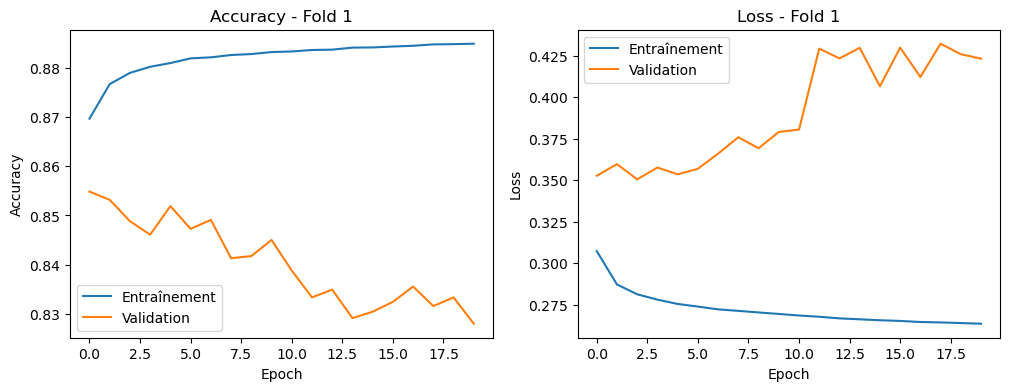

In [83]:
fold_history = history_list[0]

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fold_history.history['accuracy'], label='Entraînement')
plt.plot(fold_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Fold 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(fold_history.history['loss'], label='Entraînement')
plt.plot(fold_history.history['val_loss'], label='Validation')
plt.title('Loss - Fold 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Passons au second modèle : 
- Réseau avec 3 couches de neurones [128,64,32]
- Optimizer : Adam 
- Toujours pas de dropout 

Réseau encore sans dropout mais plus profond, pour voir si cela peut permettre d'apprendre des interactions plus complexes. 


In [84]:

acc_scores = []
loss_scores = []
history_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold + 1}/3 ---")

    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]

    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_test_fold_cat = to_categorical(y_test_fold, num_classes=3)

    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    history_list.append(history)

    loss, acc = model.evaluate(X_test_fold, y_test_fold_cat, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

    print(f"Fold {fold + 1} - Accuracy : {acc:.4f} | Loss : {loss:.4f}")

print("\n--- Résultats globaux du Modèle 2 ---")
print(f"Accuracy moyenne : {np.mean(acc_scores):.4f}")
print(f"Loss moyenne : {np.mean(loss_scores):.4f}")



--- Fold 1/3 ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Accuracy : 0.8763 | Loss : 0.2849

--- Fold 2/3 ---
Fold 2 - Accuracy : 0.8758 | Loss : 0.2919

--- Fold 3/3 ---
Fold 3 - Accuracy : 0.8740 | Loss : 0.3111

--- Résultats globaux du Modèle 2 ---
Accuracy moyenne : 0.8754
Loss moyenne : 0.2959


Représentons graphiquement la performance de ce deuxième modèle : 

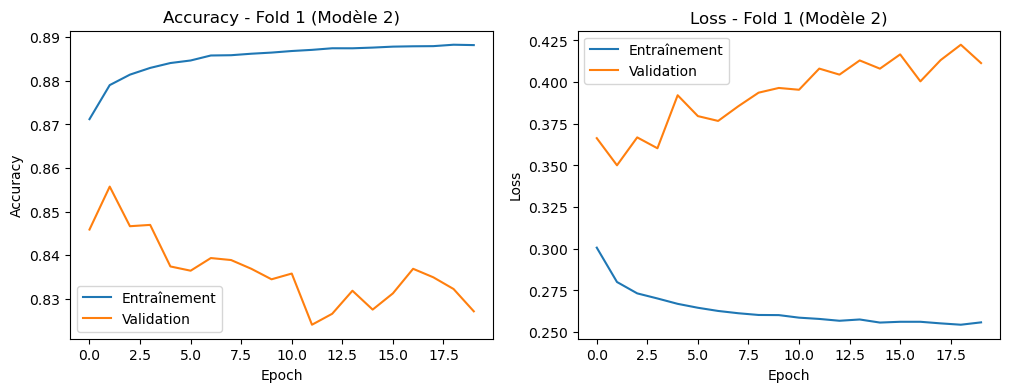

In [85]:
fold_history = history_list[0]

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fold_history.history['accuracy'], label='Entraînement')
plt.plot(fold_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Fold 1 (Modèle 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(fold_history.history['loss'], label='Entraînement')
plt.plot(fold_history.history['val_loss'], label='Validation')
plt.title('Loss - Fold 1 (Modèle 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Analyse des courbes, apport ou non de l'ajout d'une couche de neurones

Passons maintenant au troisième modèle : 
- 3 couches identiques [64,64,64]
- Optimizer : Adam 
- Dropout de 0,3 entre chaque couches, pour tenter de limiter l'overfiting


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

acc_scores = []
loss_scores = []
history_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold + 1}/3 ---")

    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]

    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_test_fold_cat = to_categorical(y_test_fold, num_classes=3)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    history_list.append(history)

    loss, acc = model.evaluate(X_test_fold, y_test_fold_cat, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

    print(f"Fold {fold + 1} - Accuracy : {acc:.4f} | Loss : {loss:.4f}")

print("\n--- Résultats globaux du Modèle 3 ---")
print(f"Accuracy moyenne : {np.mean(acc_scores):.4f}")
print(f"Loss moyenne : {np.mean(loss_scores):.4f}")



--- Fold 1/3 ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Accuracy : 0.8701 | Loss : 0.3042

--- Fold 2/3 ---
Fold 2 - Accuracy : 0.8675 | Loss : 0.3077

--- Fold 3/3 ---
Fold 3 - Accuracy : 0.8714 | Loss : 0.3030

--- Résultats globaux du Modèle 3 ---
Accuracy moyenne : 0.8697
Loss moyenne : 0.3050


Représentation graphique : 

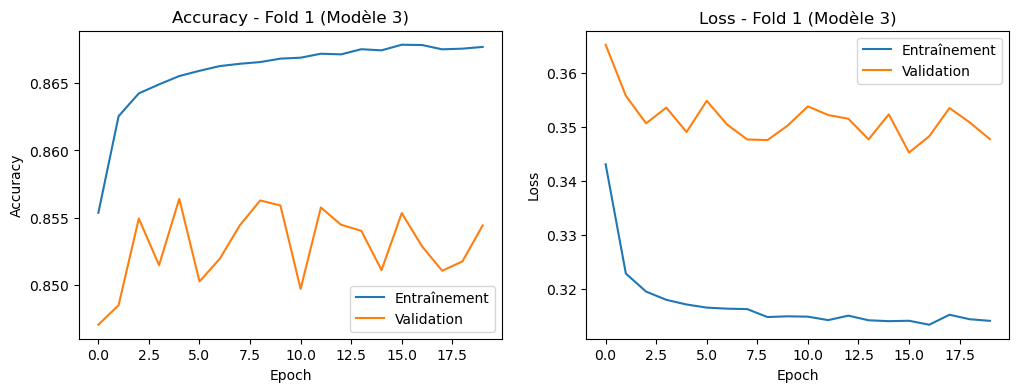

In [87]:
fold_history = history_list[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fold_history.history['accuracy'], label='Entraînement')
plt.plot(fold_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Fold 1 (Modèle 3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_history.history['loss'], label='Entraînement')
plt.plot(fold_history.history['val_loss'], label='Validation')
plt.title('Loss - Fold 1 (Modèle 3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


4 ème modèle : 
- 2 couches [64,32]
- Opitmizer : RMSprop 

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

acc_scores = []
loss_scores = []
history_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold + 1}/3 ---")

    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]

    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_test_fold_cat = to_categorical(y_test_fold, num_classes=3)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    history_list.append(history)

    loss, acc = model.evaluate(X_test_fold, y_test_fold_cat, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

    print(f"Fold {fold + 1} - Accuracy : {acc:.4f} | Loss : {loss:.4f}")

print("\n--- Résultats globaux du Modèle 4 (Optimizer RMSprop) ---")
print(f"Accuracy moyenne : {np.mean(acc_scores):.4f}")
print(f"Loss moyenne : {np.mean(loss_scores):.4f}")



--- Fold 1/3 ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Accuracy : 0.8659 | Loss : 0.4832

--- Fold 2/3 ---
Fold 2 - Accuracy : 0.8673 | Loss : 0.3379

--- Fold 3/3 ---
Fold 3 - Accuracy : 0.8660 | Loss : 0.3648

--- Résultats globaux du Modèle 4 (Optimizer RMSprop) ---
Accuracy moyenne : 0.8664
Loss moyenne : 0.3953


Représentation graphique : 

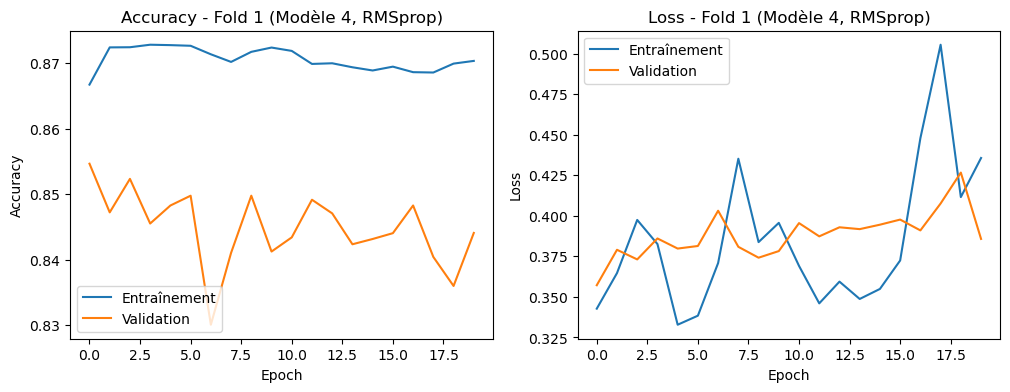

In [89]:
fold_history = history_list[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fold_history.history['accuracy'], label='Entraînement')
plt.plot(fold_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Fold 1 (Modèle 4, RMSprop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_history.history['loss'], label='Entraînement')
plt.plot(fold_history.history['val_loss'], label='Validation')
plt.title('Loss - Fold 1 (Modèle 4, RMSprop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Modèle 5 : 

- 4 couches : [256,128,64,32]
- Optimizer : Adam 
- Dropout : 0,3 

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

acc_scores = []
loss_scores = []
history_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold + 1}/3 ---")

    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]

    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_test_fold_cat = to_categorical(y_test_fold, num_classes=3)

    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    history_list.append(history)

    loss, acc = model.evaluate(X_test_fold, y_test_fold_cat, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

    print(f"Fold {fold + 1} - Accuracy : {acc:.4f} | Loss : {loss:.4f}")

print("\n--- Résultats globaux du Modèle 5 (Réseau large) ---")
print(f"Accuracy moyenne : {np.mean(acc_scores):.4f}")
print(f"Loss moyenne : {np.mean(loss_scores):.4f}")



--- Fold 1/3 ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Accuracy : 0.8745 | Loss : 0.2959

--- Fold 2/3 ---
Fold 2 - Accuracy : 0.8710 | Loss : 0.3011

--- Fold 3/3 ---
Fold 3 - Accuracy : 0.8720 | Loss : 0.3010

--- Résultats globaux du Modèle 5 (Réseau large) ---
Accuracy moyenne : 0.8725
Loss moyenne : 0.2993


Représentation graphique :

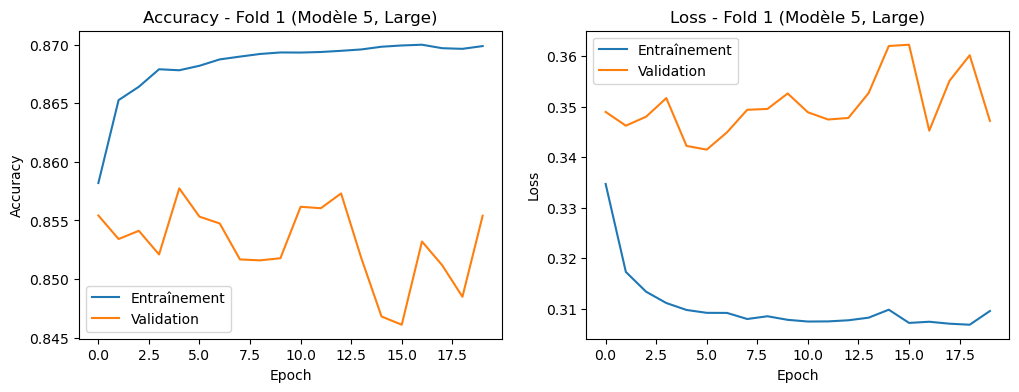

In [91]:
fold_history = history_list[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fold_history.history['accuracy'], label='Entraînement')
plt.plot(fold_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Fold 1 (Modèle 5, Large)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold_history.history['loss'], label='Entraînement')
plt.plot(fold_history.history['val_loss'], label='Validation')
plt.title('Loss - Fold 1 (Modèle 5, Large)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


CONCLUSION GLOBALE SUR LE CHOIX DES MODELES : 

Nous pouvons donc au terme de la réalisation de ces 5 différents modèles tirer les conlusions suivantes : 
- le modèle le plus simple, constitué des couches [64,32] avec l'utilisation de la fonciton d'activation Relu et l'optimiseur Adam, offre les meilleures performances 
            - Accuracy moyenne de 87,53% 
            - Perte moyenne de 0,2915
            - Comportement stable sur les courbes des folds 

- L'augmentation de la complexité par le nombre de couches ne conduit pas dans notre cas à une amélioration significative des performances, alors que cela augmente drastiquement le temps nécessaire pour faire tourner le modèle. 

- L'ajout d'un Dropout, théoriquement utile pour limiter le surapprentissage, n'a pas apporté de gain significatif, en effet aucun signe de sur ajustement majeur n'est remarqué. 

- Le changement d'optimisateur RMSprop pour remplacer Adam s'est révélé moins efficace. 

Une complication excessive serait dans notre cas simplement contreproductive. 

Nous pouvons trouver plusieurs explication à ces résultats plutôt positif avec un réseau pourtant simple. 

1- La qualité de préparation des données : 
         - nous avons choisi des features pertinents (moneyness, distance avec le strike, greeks, volatilité...)
        - nous avons éliminé les trous dans la base de données

2- Le travail de labellisation des donnnées et le fait de le baser sur les quantiles extrêmes: 
        - création d'une frontière claire entre ce qui est sous, bien et sur pricé. 
        - on réduit les ambiguïtés et on se concentre sur les anomalies le splus nettes.

3- Nous avons utilisés la méthode de la Cross Validation :
        - cela a permis d'éviter le sur-apprentissage qui aurait été lié à un split favorable, ce qui peut expliquer l'impacte faible de l'ajout du Dropout. 